# models comparison

this is model comparison accross models. The results are only related to one of the color, number and both models.  if you wanna change the color, number and both models, you have to change it through the file_both_greedy for example, if you put 11 for all, it wil be color model, if you put 12 it will be number and if you put 14 it will be both model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore", category=UserWarning, append=True)
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from itertools import combinations
import seaborn as sns

# BIC and mcFadden_R2
the first way to compare models is bayesian information criterion; BICs don't have a meaning by themselves it's the delta BIC between models that decides which model in better. the model with smaller BIC explains the behavior better.
## interpretation:

about BIC difference absolute amount:
0–2: Not worth more than a bare mention
2–6: good
6–10: Strong
+10: Very strong

# both model

In [2]:
output_dir = r"14_RL_agent_TDlearn_output_model_comparison_across_models"
os.makedirs(output_dir, exist_ok=True)

file_both_greedy = "13_RL_agent_TDlearn_output/models_evaluation.csv"
file_both_softmax = "13_RL_agent_TDlearn_output_softmax/models_evaluation.csv"
file_both_rs = "13_RL_agent_TDlearn_output_risk_sensitive/models_evaluation.csv"
file_both_wsls = "13_RL_agent_TDlearn_output_wsls/models_evaluation.csv"
file_both_dualQ = "13_RL_agent_TDlearn_output_risk_dualQ/models_evaluation.csv"
file_risk_sensitive_sanity_check = "13_RL_agent_TDlearn_output_risk_sensitive_sanity_check/models_evaluation.csv"
file_both_dualQ_no_eta = "13_RL_agent_TDlearn_output_risk_dualQ_no_eta/models_evaluation.csv"



df_both_greedy = pd.read_csv(file_both_greedy)
df_both_softmax = pd.read_csv(file_both_softmax)
df_both_wsls = pd.read_csv(file_both_wsls)
df_both_rs = pd.read_csv(file_both_rs)
df_both_dualQ = pd.read_csv(file_both_dualQ)
df_both_dualQ_no_eta = pd.read_csv(file_both_dualQ_no_eta)
df_both_rs_sanity_check = pd.read_csv(file_risk_sensitive_sanity_check)

# models evaluation metrics

Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_metrics_both.pdf


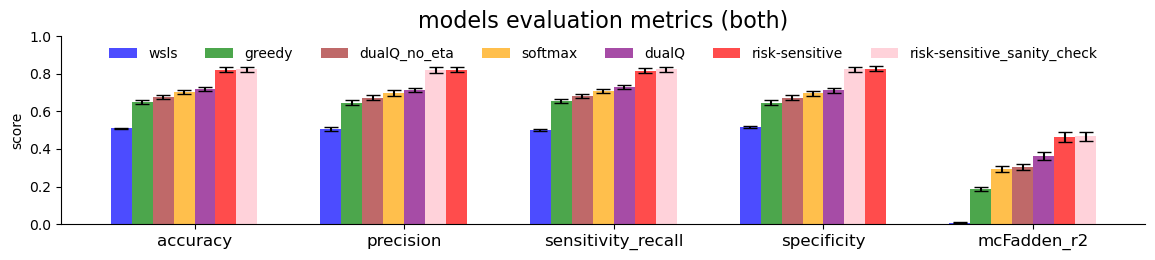

In [3]:
metrics = ['accuracy', 'precision', 'sensitivity_recall', 'specificity', 'mcFadden_r2']
conditions = ['wsls','greedy', 'softmax', 'risk-sensitive', 'dualQ', 'dualQ_no_eta', 'risk-sensitive_sanity_check']
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']


# Compute means and SEMs
means = [
    df_both_wsls[metrics].mean().values,
    df_both_greedy[metrics].mean().values,
    df_both_softmax[metrics].mean().values,
    df_both_rs[metrics].mean().values,
    df_both_dualQ[metrics].mean().values,
    df_both_dualQ_no_eta[metrics].mean().values,
    df_both_rs_sanity_check[metrics].mean().values
]

sems = [
    df_both_wsls[metrics].sem().values,
    df_both_greedy[metrics].sem().values,
    df_both_softmax[metrics].sem().values,
    df_both_rs[metrics].sem().values,
    df_both_dualQ[metrics].sem().values,
    df_both_dualQ_no_eta[metrics].sem().values,
    df_both_rs_sanity_check[metrics].sem().values

]

# Reorganize means and sems for sorting
means = np.array(means)  # shape: (n_conditions, n_metrics)
sems = np.array(sems)

n_conditions = len(conditions)
n_metrics = len(metrics)

x = np.arange(n_metrics) * 1  # bars spacing
width = 0.1

fig, ax = plt.subplots(figsize=(12, 3))

for metric_idx in range(n_metrics):
    metric_means = means[:, metric_idx]
    metric_sems = sems[:, metric_idx]
    sorted_indices = np.argsort(metric_means)
    sorted_means = metric_means[sorted_indices]
    sorted_sems = metric_sems[sorted_indices]
    sorted_conditions = [conditions[i] for i in sorted_indices]
    sorted_colors = [mcolors.to_rgba(colors[i], alpha=0.7) for i in sorted_indices]

    for i, (mean, sem, label, color) in enumerate(zip(sorted_means, sorted_sems, sorted_conditions, sorted_colors)):
        ax.bar(
            x[metric_idx] + (i - (n_conditions / 2)) * width,
            mean,
            width,
            yerr=sem,
            capsize=5,
            color=color,
            label=label if metric_idx == 0 else None
        )

# Labels and aesthetics
ax.set_ylabel('score')
ax.set_title('models evaluation metrics (both)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend under title in one row
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=n_conditions, frameon=False)



plt.tight_layout(rect=[0, 0, 1, 0.9])
filename = os.path.join(output_dir, "models_evaluation_metrics_both.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.show()


Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_metrics_significancy_test_both.pdf


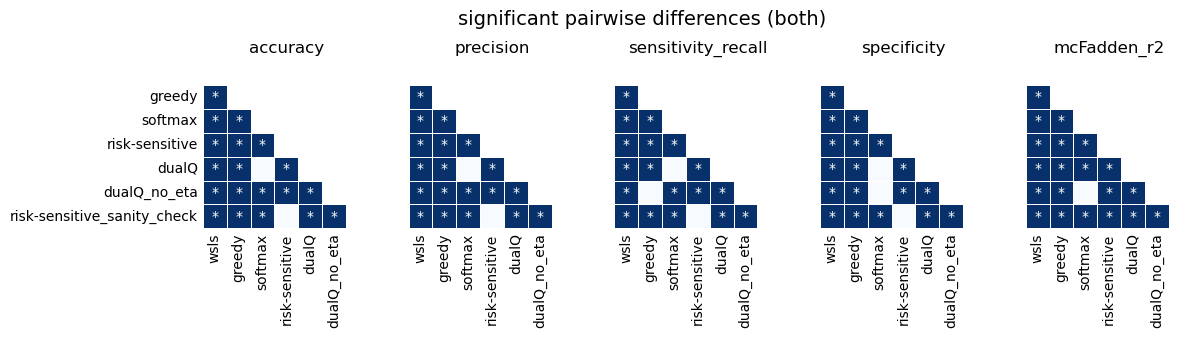

In [4]:
dfs = [
    df_both_wsls, df_both_greedy, df_both_softmax, df_both_rs,
    df_both_dualQ, df_both_dualQ_no_eta, df_both_rs_sanity_check
]

def compute_significance_matrix(metric, alpha):
    size = len(conditions)
    significance = np.full((size, size), '', dtype=object)
    for i, j in combinations(range(size), 2):
        stat, p = ttest_rel(dfs[i][metric], dfs[j][metric])
        if p < alpha:
            significance[i, j] = '*'
            significance[j, i] = '*'
    return pd.DataFrame(significance, index=conditions, columns=conditions)

n_comparisons = len(conditions) * (len(conditions) - 1) / 2
alpha = 0.05 / n_comparisons

fig, axes = plt.subplots(1, len(metrics), figsize=(12, 5), constrained_layout=True)

for i, metric in enumerate(metrics):
    sig_df = compute_significance_matrix(metric, alpha)
    binary_matrix = np.where(sig_df == '*', 1, 0).astype(float)

    np.fill_diagonal(binary_matrix, np.nan)
    for k in range(len(conditions)):
        sig_df.iloc[k, k] = ''

    mask = np.triu(np.ones_like(binary_matrix, dtype=bool))

    sns.heatmap(
        binary_matrix, ax=axes[i],
        annot=sig_df, fmt='', cmap='Blues', cbar=False,
        linewidths=0.5, square=True,
        xticklabels=conditions,
        yticklabels=conditions if i == 0 else False,
        mask=mask
    )

    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=90)

    # hide the wsls y-label only on the first subplot
    if i == 0:
        yt = conditions.copy()
        yt[conditions.index('wsls')] = ''
        axes[i].set_yticklabels(yt)
    else:
        axes[i].tick_params(axis='y', left=False)

    # hide the risk-sensitive_sanity_check x-label
    xt = conditions.copy()
    xt[conditions.index('risk-sensitive_sanity_check')] = ''
    axes[i].set_xticklabels(xt, rotation=90)


    axes[i].tick_params(axis='both', which='both', length=0)


plt.tight_layout(rect=[0, 0, 1, 0.9])
filename = os.path.join(output_dir, "models_evaluation_metrics_significancy_test_both.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.suptitle("significant pairwise differences (both)", fontsize=14, y=0.72)
plt.show()


# BIC and R2 calculations

In [5]:
bic_wsls = df_both_wsls["BIC"]
bic_greedy = df_both_greedy["BIC"]
bic_softmax = df_both_softmax["BIC"]
bic_rs = df_both_rs["BIC"]
bic_dualQ = df_both_dualQ["BIC"]
bic_dualQ_no_eta = df_both_dualQ_no_eta["BIC"]
bic_rs_sanity_check = df_both_rs_sanity_check["BIC"]

aic_wsls = df_both_wsls["AIC"]
aic_greedy = df_both_greedy["AIC"]
aic_softmax = df_both_softmax["AIC"]
aic_rs = df_both_rs["AIC"]
aic_dualQ = df_both_dualQ["AIC"]
aic_dualQ_no_eta = df_both_dualQ_no_eta["AIC"]
aic_rs_sanity_check = df_both_rs_sanity_check["AIC"]


mcFadden_r2_wsls = df_both_wsls["mcFadden_r2"]
mcFadden_r2_greedy = df_both_greedy["mcFadden_r2"]
mcFadden_r2_softmax = df_both_softmax["mcFadden_r2"]
mcFadden_r2_rs = df_both_rs["mcFadden_r2"]
mcFadden_r2_dualQ = df_both_dualQ["mcFadden_r2"]
mcFadden_r2_dualQ_no_eta = df_both_dualQ_no_eta["mcFadden_r2"]
mcFadden_r2_rs_sanity_check = df_both_rs_sanity_check["mcFadden_r2"]


##############################################################################
# BIC:

delta_bic_wsls_greedy = bic_wsls - bic_greedy
delta_bic_wsls_softmax = bic_wsls - bic_softmax
delta_bic_wsls_rs = bic_wsls - bic_rs
delta_bic_wsls_dualQ = bic_wsls - bic_dualQ
delta_bic_wsls_dualQ_no_eta = bic_wsls - bic_dualQ_no_eta
delta_bic_wsls_rs_sanity_check = bic_wsls - bic_rs_sanity_check

delta_bic_greedy_softmax = bic_greedy - bic_softmax
delta_bic_greedy_rs = bic_greedy - bic_rs
delta_bic_greedy_dualQ = bic_greedy - bic_dualQ
delta_bic_greedy_dualQ_no_eta = bic_greedy - bic_dualQ_no_eta
delta_bic_greedy_rs_sanity_check = bic_greedy - bic_rs_sanity_check

delta_bic_softmax_rs = bic_softmax - bic_rs
delta_bic_softmax_dualQ = bic_softmax - bic_dualQ
delta_bic_softmax_dualQ_no_eta = bic_softmax - bic_dualQ_no_eta
delta_bic_softmax_rs_sanity_check = bic_softmax - bic_rs_sanity_check

delta_bic_rs_dualQ = bic_rs - bic_dualQ
delta_bic_rs_dualQ_no_eta = bic_rs - bic_dualQ_no_eta
delta_bic_rs_rs_sanity_check = bic_rs - bic_rs_sanity_check

delta_bic_dualQ_dualQ_no_eta = bic_dualQ - bic_dualQ_no_eta
delta_bic_dualQ_rs_sanity_check = bic_dualQ - bic_rs_sanity_check

delta_bic_dualQ_no_eta_rs_sanity_check = bic_dualQ_no_eta - bic_rs_sanity_check

##############################################################################
# AIC:

delta_aic_wsls_greedy = aic_wsls - aic_greedy
delta_aic_wsls_softmax = aic_wsls - aic_softmax
delta_aic_wsls_rs = aic_wsls - aic_rs
delta_aic_wsls_dualQ = aic_wsls - aic_dualQ
delta_aic_wsls_dualQ_no_eta = aic_wsls - aic_dualQ_no_eta
delta_aic_wsls_rs_sanity_check = aic_wsls - aic_rs_sanity_check

delta_aic_greedy_softmax = aic_greedy - aic_softmax
delta_aic_greedy_rs = aic_greedy - aic_rs
delta_aic_greedy_dualQ = aic_greedy - aic_dualQ
delta_aic_greedy_dualQ_no_eta = aic_greedy - aic_dualQ_no_eta
delta_aic_greedy_rs_sanity_check = aic_greedy - aic_rs_sanity_check

delta_aic_softmax_rs = aic_softmax - aic_rs
delta_aic_softmax_dualQ = aic_softmax - aic_dualQ
delta_aic_softmax_dualQ_no_eta = aic_softmax - aic_dualQ_no_eta
delta_aic_softmax_rs_sanity_check = aic_softmax - aic_rs_sanity_check

delta_aic_rs_dualQ = aic_rs - aic_dualQ
delta_aic_rs_dualQ_no_eta = aic_rs - aic_dualQ_no_eta
delta_aic_rs_rs_sanity_check = aic_rs - aic_rs_sanity_check

delta_aic_dualQ_dualQ_no_eta = aic_dualQ - aic_dualQ_no_eta
delta_aic_dualQ_rs_sanity_check = aic_dualQ - aic_rs_sanity_check

delta_aic_dualQ_no_eta_rs_sanity_check = aic_dualQ_no_eta - aic_rs_sanity_check


##############################################################################
# mcFadden_r2:

delta_mcFadden_r2_wsls_greedy = mcFadden_r2_wsls - mcFadden_r2_greedy
delta_mcFadden_r2_wsls_softmax = mcFadden_r2_wsls - mcFadden_r2_softmax
delta_mcFadden_r2_wsls_rs = mcFadden_r2_wsls - mcFadden_r2_rs
delta_mcFadden_r2_wsls_dualQ = mcFadden_r2_wsls - mcFadden_r2_dualQ
delta_mcFadden_r2_wsls_dualQ_no_eta = mcFadden_r2_wsls - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_wsls_rs_sanity_check = mcFadden_r2_wsls - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_greedy_softmax = mcFadden_r2_greedy - mcFadden_r2_softmax
delta_mcFadden_r2_greedy_rs = mcFadden_r2_greedy - mcFadden_r2_rs
delta_mcFadden_r2_greedy_dualQ = mcFadden_r2_greedy - mcFadden_r2_dualQ
delta_mcFadden_r2_greedy_dualQ_no_eta = mcFadden_r2_greedy - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_greedy_rs_sanity_check = mcFadden_r2_greedy - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_softmax_rs = mcFadden_r2_softmax - mcFadden_r2_rs
delta_mcFadden_r2_softmax_dualQ = mcFadden_r2_softmax - mcFadden_r2_dualQ
delta_mcFadden_r2_softmax_dualQ_no_eta = mcFadden_r2_softmax - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_softmax_rs_sanity_check = mcFadden_r2_softmax - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_rs_dualQ = mcFadden_r2_rs - mcFadden_r2_dualQ
delta_mcFadden_r2_rs_dualQ_no_eta = mcFadden_r2_rs - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_rs_rs_sanity_check = mcFadden_r2_rs - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_dualQ_dualQ_no_eta = mcFadden_r2_dualQ - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_dualQ_rs_sanity_check = mcFadden_r2_dualQ - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_dualQ_no_eta_rs_sanity_check = mcFadden_r2_dualQ_no_eta - mcFadden_r2_rs_sanity_check

# BIC and R2 calculations visualizations

C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3339700394.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_bic = axs[0].boxplot(
C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3339700394.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_aic = axs[1].boxplot(
C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3339700394.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_mcFadden = axs[2].boxplot(


Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_comparison_bic_r2_all_pairs_both.pdf


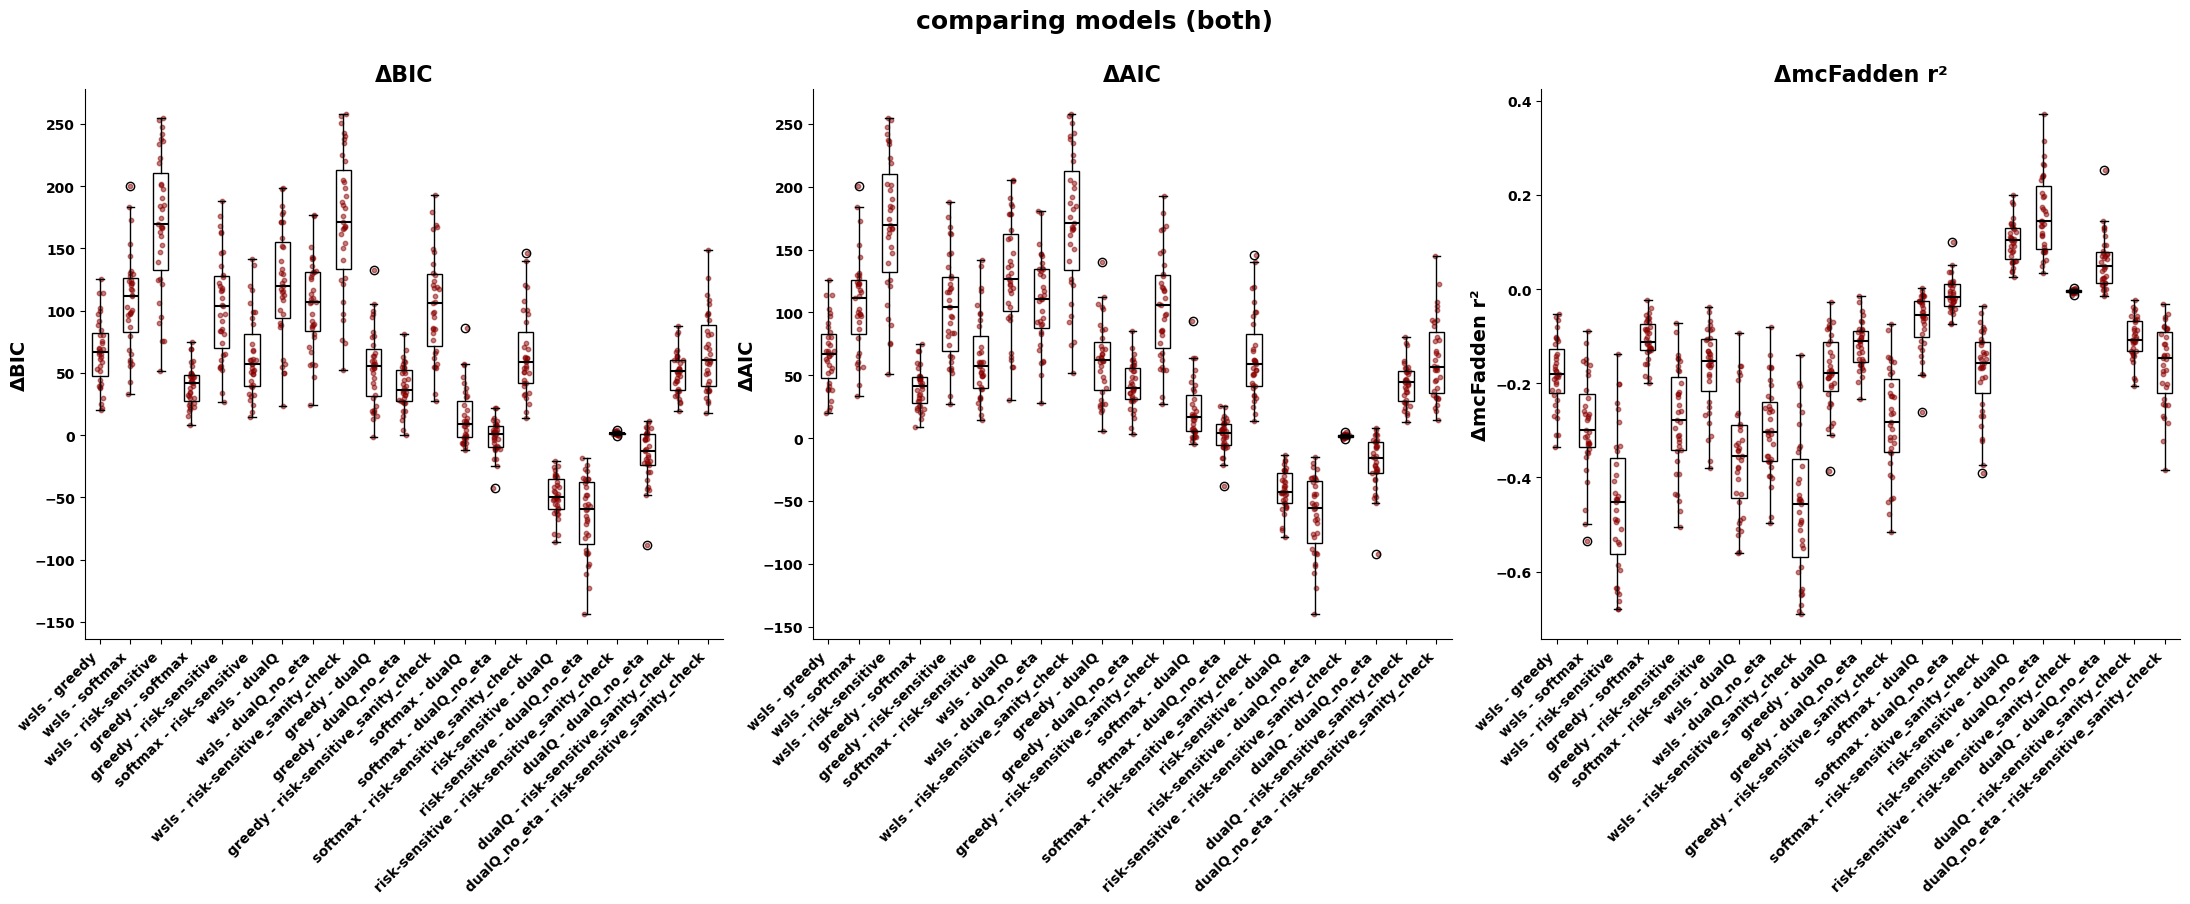

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(22, 10))

# Prepare deltas for all pairwise comparisons (wsls, greedy, softmax, rs)
bic_deltas = [
    delta_bic_wsls_greedy,
    delta_bic_wsls_softmax,
    delta_bic_wsls_rs,
    delta_bic_greedy_softmax,
    delta_bic_greedy_rs,
    delta_bic_softmax_rs,
    delta_bic_wsls_dualQ,
    delta_bic_wsls_dualQ_no_eta,
    delta_bic_wsls_rs_sanity_check,
    delta_bic_greedy_dualQ,
    delta_bic_greedy_dualQ_no_eta,
    delta_bic_greedy_rs_sanity_check,
    delta_bic_softmax_dualQ,
    delta_bic_softmax_dualQ_no_eta,
    delta_bic_softmax_rs_sanity_check,
    delta_bic_rs_dualQ,
    delta_bic_rs_dualQ_no_eta,
    delta_bic_rs_rs_sanity_check,
    delta_bic_dualQ_dualQ_no_eta,
    delta_bic_dualQ_rs_sanity_check,
    delta_bic_dualQ_no_eta_rs_sanity_check
]
aic_deltas = [
    delta_aic_wsls_greedy,
    delta_aic_wsls_softmax,
    delta_aic_wsls_rs,
    delta_aic_greedy_softmax,
    delta_aic_greedy_rs,
    delta_aic_softmax_rs,
    delta_aic_wsls_dualQ,
    delta_aic_wsls_dualQ_no_eta,
    delta_aic_wsls_rs_sanity_check,
    delta_aic_greedy_dualQ,
    delta_aic_greedy_dualQ_no_eta,
    delta_aic_greedy_rs_sanity_check,
    delta_aic_softmax_dualQ,
    delta_aic_softmax_dualQ_no_eta,
    delta_aic_softmax_rs_sanity_check,
    delta_aic_rs_dualQ,
    delta_aic_rs_dualQ_no_eta,
    delta_aic_rs_rs_sanity_check,
    delta_aic_dualQ_dualQ_no_eta,
    delta_aic_dualQ_rs_sanity_check,
    delta_aic_dualQ_no_eta_rs_sanity_check
]
mcFadden_r2_deltas = [
    delta_mcFadden_r2_wsls_greedy,
    delta_mcFadden_r2_wsls_softmax,
    delta_mcFadden_r2_wsls_rs,
    delta_mcFadden_r2_greedy_softmax,
    delta_mcFadden_r2_greedy_rs,
    delta_mcFadden_r2_softmax_rs,
    delta_mcFadden_r2_wsls_dualQ,
    delta_mcFadden_r2_wsls_dualQ_no_eta,
    delta_mcFadden_r2_wsls_rs_sanity_check,
    delta_mcFadden_r2_greedy_dualQ,
    delta_mcFadden_r2_greedy_dualQ_no_eta,
    delta_mcFadden_r2_greedy_rs_sanity_check,
    delta_mcFadden_r2_softmax_dualQ,
    delta_mcFadden_r2_softmax_dualQ_no_eta,
    delta_mcFadden_r2_softmax_rs_sanity_check,
    delta_mcFadden_r2_rs_dualQ,
    delta_mcFadden_r2_rs_dualQ_no_eta,
    delta_mcFadden_r2_rs_rs_sanity_check,
    delta_mcFadden_r2_dualQ_dualQ_no_eta,
    delta_mcFadden_r2_dualQ_rs_sanity_check,
    delta_mcFadden_r2_dualQ_no_eta_rs_sanity_check
]

labels = [
    "wsls - greedy",
    "wsls - softmax",
    "wsls - risk-sensitive",
    "greedy - softmax",
    "greedy - risk-sensitive",
    "softmax - risk-sensitive",
    "wsls - dualQ",
    "wsls - dualQ_no_eta",
    "wsls - risk-sensitive_sanity_check",
    "greedy - dualQ",
    "greedy - dualQ_no_eta",
    "greedy - risk-sensitive_sanity_check",
    "softmax - dualQ",
    "softmax - dualQ_no_eta",
    "softmax - risk-sensitive_sanity_check",
    "risk-sensitive - dualQ",
    "risk-sensitive - dualQ_no_eta",
    "risk-sensitive - risk-sensitive_sanity_check",
    "dualQ - dualQ_no_eta",
    "dualQ - risk-sensitive_sanity_check",
    "dualQ_no_eta - risk-sensitive_sanity_check"
]

# Plot BIC deltas
box_bic = axs[0].boxplot(
    bic_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_bic['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(bic_deltas):
    axs[0].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[0].set_title("ΔBIC", fontsize=16, fontweight='bold')
axs[0].set_ylabel("ΔBIC", fontsize=14, fontweight='bold')

# Plot AIC deltas
box_aic = axs[1].boxplot(
    aic_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_aic['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(aic_deltas):
    axs[1].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[1].set_title("ΔAIC", fontsize=16, fontweight='bold')
axs[1].set_ylabel("ΔAIC", fontsize=14, fontweight='bold')

# Plot McFadden R2 deltas
box_mcFadden = axs[2].boxplot(
    mcFadden_r2_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_mcFadden['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(mcFadden_r2_deltas):
    axs[2].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[2].set_title("ΔmcFadden r²", fontsize=16, fontweight='bold')
axs[2].set_ylabel("ΔmcFadden r²", fontsize=14, fontweight='bold')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle('comparing models (both)', fontsize=18, fontweight='bold', y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])

filename = os.path.join(output_dir, "models_evaluation_comparison_bic_r2_all_pairs_both.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.show()


# number

In [7]:
output_dir = r"14_RL_agent_TDlearn_output_model_comparison_across_models"
os.makedirs(output_dir, exist_ok=True)

file_both_greedy = "12_RL_agent_TDlearn_output/models_evaluation.csv"
file_both_softmax = "12_RL_agent_TDlearn_output_softmax/models_evaluation.csv"
file_both_rs = "12_RL_agent_TDlearn_output_risk_sensitive/models_evaluation.csv"
file_both_wsls = "12_RL_agent_TDlearn_output_wsls/models_evaluation.csv"
file_both_dualQ = "12_RL_agent_TDlearn_output_risk_dualQ/models_evaluation.csv"
file_risk_sensitive_sanity_check = "12_RL_agent_TDlearn_output_risk_sensitive_sanity_check/models_evaluation.csv"
file_both_dualQ_no_eta = "12_RL_agent_TDlearn_output_risk_dualQ_no_eta/models_evaluation.csv"



df_both_greedy = pd.read_csv(file_both_greedy)
df_both_softmax = pd.read_csv(file_both_softmax)
df_both_wsls = pd.read_csv(file_both_wsls)
df_both_rs = pd.read_csv(file_both_rs)
df_both_dualQ = pd.read_csv(file_both_dualQ)
df_both_dualQ_no_eta = pd.read_csv(file_both_dualQ_no_eta)
df_both_rs_sanity_check = pd.read_csv(file_risk_sensitive_sanity_check)

Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_metrics_number.pdf


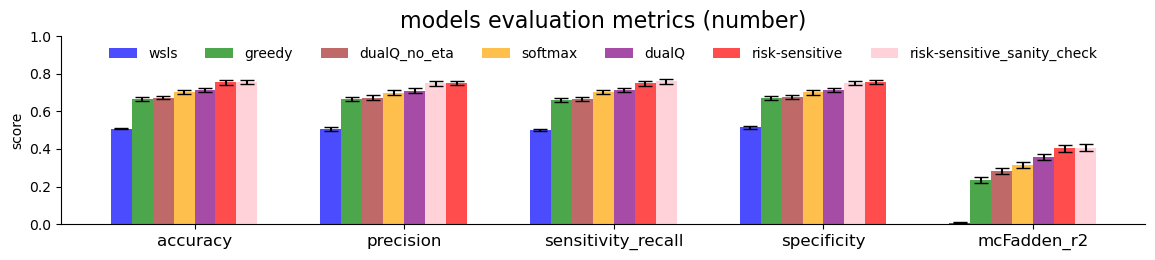

In [8]:
metrics = ['accuracy', 'precision', 'sensitivity_recall', 'specificity', 'mcFadden_r2']
conditions = ['wsls','greedy', 'softmax', 'risk-sensitive', 'dualQ', 'dualQ_no_eta', 'risk-sensitive_sanity_check']
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']


# Compute means and SEMs
means = [
    df_both_wsls[metrics].mean().values,
    df_both_greedy[metrics].mean().values,
    df_both_softmax[metrics].mean().values,
    df_both_rs[metrics].mean().values,
    df_both_dualQ[metrics].mean().values,
    df_both_dualQ_no_eta[metrics].mean().values,
    df_both_rs_sanity_check[metrics].mean().values
]

sems = [
    df_both_wsls[metrics].sem().values,
    df_both_greedy[metrics].sem().values,
    df_both_softmax[metrics].sem().values,
    df_both_rs[metrics].sem().values,
    df_both_dualQ[metrics].sem().values,
    df_both_dualQ_no_eta[metrics].sem().values,
    df_both_rs_sanity_check[metrics].sem().values

]

# Reorganize means and sems for sorting
means = np.array(means)  # shape: (n_conditions, n_metrics)
sems = np.array(sems)

n_conditions = len(conditions)
n_metrics = len(metrics)

x = np.arange(n_metrics) * 1  # bars spacing
width = 0.1

fig, ax = plt.subplots(figsize=(12, 3))

for metric_idx in range(n_metrics):
    metric_means = means[:, metric_idx]
    metric_sems = sems[:, metric_idx]
    sorted_indices = np.argsort(metric_means)
    sorted_means = metric_means[sorted_indices]
    sorted_sems = metric_sems[sorted_indices]
    sorted_conditions = [conditions[i] for i in sorted_indices]
    sorted_colors = [mcolors.to_rgba(colors[i], alpha=0.7) for i in sorted_indices]

    for i, (mean, sem, label, color) in enumerate(zip(sorted_means, sorted_sems, sorted_conditions, sorted_colors)):
        ax.bar(
            x[metric_idx] + (i - (n_conditions / 2)) * width,
            mean,
            width,
            yerr=sem,
            capsize=5,
            color=color,
            label=label if metric_idx == 0 else None
        )

# Labels and aesthetics
ax.set_ylabel('score')
ax.set_title('models evaluation metrics (number)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend under title in one row
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=n_conditions, frameon=False)



plt.tight_layout(rect=[0, 0, 1, 0.9])
filename = os.path.join(output_dir, "models_evaluation_metrics_number.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.show()


Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_metrics_significancy_test_number.pdf


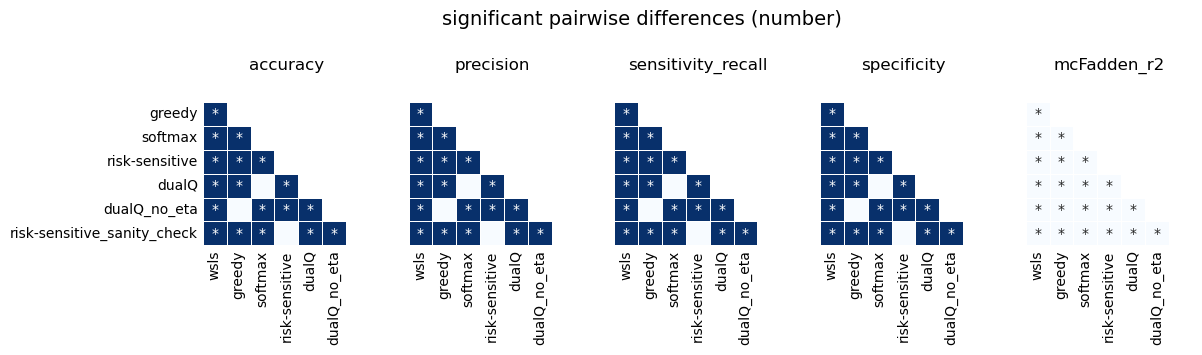

In [9]:
dfs = [
    df_both_wsls, df_both_greedy, df_both_softmax, df_both_rs,
    df_both_dualQ, df_both_dualQ_no_eta, df_both_rs_sanity_check
]

def compute_significance_matrix(metric, alpha):
    size = len(conditions)
    significance = np.full((size, size), '', dtype=object)
    for i, j in combinations(range(size), 2):
        stat, p = ttest_rel(dfs[i][metric], dfs[j][metric])
        if p < alpha:
            significance[i, j] = '*'
            significance[j, i] = '*'
    return pd.DataFrame(significance, index=conditions, columns=conditions)

n_comparisons = len(conditions) * (len(conditions) - 1) / 2
alpha = 0.05 / n_comparisons

fig, axes = plt.subplots(1, len(metrics), figsize=(12, 5), constrained_layout=True)

for i, metric in enumerate(metrics):
    sig_df = compute_significance_matrix(metric, alpha)
    binary_matrix = np.where(sig_df == '*', 1, 0).astype(float)

    np.fill_diagonal(binary_matrix, np.nan)
    for k in range(len(conditions)):
        sig_df.iloc[k, k] = ''

    mask = np.triu(np.ones_like(binary_matrix, dtype=bool))

    sns.heatmap(
        binary_matrix, ax=axes[i],
        annot=sig_df, fmt='', cmap='Blues', cbar=False,
        linewidths=0.5, square=True,
        xticklabels=conditions,
        yticklabels=conditions if i == 0 else False,
        mask=mask
    )

    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=90)

    # hide the wsls y-label only on the first subplot
    if i == 0:
        yt = conditions.copy()
        yt[conditions.index('wsls')] = ''
        axes[i].set_yticklabels(yt)
    else:
        axes[i].tick_params(axis='y', left=False)

    # hide the risk-sensitive_sanity_check x-label
    xt = conditions.copy()
    xt[conditions.index('risk-sensitive_sanity_check')] = ''
    axes[i].set_xticklabels(xt, rotation=90)


    axes[i].tick_params(axis='both', which='both', length=0)


plt.suptitle("significant pairwise differences (number)", fontsize=14, y=0.72)


plt.tight_layout(rect=[0, 0, 1, 0.9])
filename = os.path.join(output_dir, "models_evaluation_metrics_significancy_test_number.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.show()


In [10]:
bic_wsls = df_both_wsls["BIC"]
bic_greedy = df_both_greedy["BIC"]
bic_softmax = df_both_softmax["BIC"]
bic_rs = df_both_rs["BIC"]
bic_dualQ = df_both_dualQ["BIC"]
bic_dualQ_no_eta = df_both_dualQ_no_eta["BIC"]
bic_rs_sanity_check = df_both_rs_sanity_check["BIC"]

aic_wsls = df_both_wsls["AIC"]
aic_greedy = df_both_greedy["AIC"]
aic_softmax = df_both_softmax["AIC"]
aic_rs = df_both_rs["AIC"]
aic_dualQ = df_both_dualQ["AIC"]
aic_dualQ_no_eta = df_both_dualQ_no_eta["AIC"]
aic_rs_sanity_check = df_both_rs_sanity_check["AIC"]


mcFadden_r2_wsls = df_both_wsls["mcFadden_r2"]
mcFadden_r2_greedy = df_both_greedy["mcFadden_r2"]
mcFadden_r2_softmax = df_both_softmax["mcFadden_r2"]
mcFadden_r2_rs = df_both_rs["mcFadden_r2"]
mcFadden_r2_dualQ = df_both_dualQ["mcFadden_r2"]
mcFadden_r2_dualQ_no_eta = df_both_dualQ_no_eta["mcFadden_r2"]
mcFadden_r2_rs_sanity_check = df_both_rs_sanity_check["mcFadden_r2"]


##############################################################################
# BIC:

delta_bic_wsls_greedy = bic_wsls - bic_greedy
delta_bic_wsls_softmax = bic_wsls - bic_softmax
delta_bic_wsls_rs = bic_wsls - bic_rs
delta_bic_wsls_dualQ = bic_wsls - bic_dualQ
delta_bic_wsls_dualQ_no_eta = bic_wsls - bic_dualQ_no_eta
delta_bic_wsls_rs_sanity_check = bic_wsls - bic_rs_sanity_check

delta_bic_greedy_softmax = bic_greedy - bic_softmax
delta_bic_greedy_rs = bic_greedy - bic_rs
delta_bic_greedy_dualQ = bic_greedy - bic_dualQ
delta_bic_greedy_dualQ_no_eta = bic_greedy - bic_dualQ_no_eta
delta_bic_greedy_rs_sanity_check = bic_greedy - bic_rs_sanity_check

delta_bic_softmax_rs = bic_softmax - bic_rs
delta_bic_softmax_dualQ = bic_softmax - bic_dualQ
delta_bic_softmax_dualQ_no_eta = bic_softmax - bic_dualQ_no_eta
delta_bic_softmax_rs_sanity_check = bic_softmax - bic_rs_sanity_check

delta_bic_rs_dualQ = bic_rs - bic_dualQ
delta_bic_rs_dualQ_no_eta = bic_rs - bic_dualQ_no_eta
delta_bic_rs_rs_sanity_check = bic_rs - bic_rs_sanity_check

delta_bic_dualQ_dualQ_no_eta = bic_dualQ - bic_dualQ_no_eta
delta_bic_dualQ_rs_sanity_check = bic_dualQ - bic_rs_sanity_check

delta_bic_dualQ_no_eta_rs_sanity_check = bic_dualQ_no_eta - bic_rs_sanity_check

##############################################################################
# AIC:

delta_aic_wsls_greedy = aic_wsls - aic_greedy
delta_aic_wsls_softmax = aic_wsls - aic_softmax
delta_aic_wsls_rs = aic_wsls - aic_rs
delta_aic_wsls_dualQ = aic_wsls - aic_dualQ
delta_aic_wsls_dualQ_no_eta = aic_wsls - aic_dualQ_no_eta
delta_aic_wsls_rs_sanity_check = aic_wsls - aic_rs_sanity_check

delta_aic_greedy_softmax = aic_greedy - aic_softmax
delta_aic_greedy_rs = aic_greedy - aic_rs
delta_aic_greedy_dualQ = aic_greedy - aic_dualQ
delta_aic_greedy_dualQ_no_eta = aic_greedy - aic_dualQ_no_eta
delta_aic_greedy_rs_sanity_check = aic_greedy - aic_rs_sanity_check

delta_aic_softmax_rs = aic_softmax - aic_rs
delta_aic_softmax_dualQ = aic_softmax - aic_dualQ
delta_aic_softmax_dualQ_no_eta = aic_softmax - aic_dualQ_no_eta
delta_aic_softmax_rs_sanity_check = aic_softmax - aic_rs_sanity_check

delta_aic_rs_dualQ = aic_rs - aic_dualQ
delta_aic_rs_dualQ_no_eta = aic_rs - aic_dualQ_no_eta
delta_aic_rs_rs_sanity_check = aic_rs - aic_rs_sanity_check

delta_aic_dualQ_dualQ_no_eta = aic_dualQ - aic_dualQ_no_eta
delta_aic_dualQ_rs_sanity_check = aic_dualQ - aic_rs_sanity_check

delta_aic_dualQ_no_eta_rs_sanity_check = aic_dualQ_no_eta - aic_rs_sanity_check


##############################################################################
# mcFadden_r2:

delta_mcFadden_r2_wsls_greedy = mcFadden_r2_wsls - mcFadden_r2_greedy
delta_mcFadden_r2_wsls_softmax = mcFadden_r2_wsls - mcFadden_r2_softmax
delta_mcFadden_r2_wsls_rs = mcFadden_r2_wsls - mcFadden_r2_rs
delta_mcFadden_r2_wsls_dualQ = mcFadden_r2_wsls - mcFadden_r2_dualQ
delta_mcFadden_r2_wsls_dualQ_no_eta = mcFadden_r2_wsls - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_wsls_rs_sanity_check = mcFadden_r2_wsls - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_greedy_softmax = mcFadden_r2_greedy - mcFadden_r2_softmax
delta_mcFadden_r2_greedy_rs = mcFadden_r2_greedy - mcFadden_r2_rs
delta_mcFadden_r2_greedy_dualQ = mcFadden_r2_greedy - mcFadden_r2_dualQ
delta_mcFadden_r2_greedy_dualQ_no_eta = mcFadden_r2_greedy - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_greedy_rs_sanity_check = mcFadden_r2_greedy - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_softmax_rs = mcFadden_r2_softmax - mcFadden_r2_rs
delta_mcFadden_r2_softmax_dualQ = mcFadden_r2_softmax - mcFadden_r2_dualQ
delta_mcFadden_r2_softmax_dualQ_no_eta = mcFadden_r2_softmax - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_softmax_rs_sanity_check = mcFadden_r2_softmax - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_rs_dualQ = mcFadden_r2_rs - mcFadden_r2_dualQ
delta_mcFadden_r2_rs_dualQ_no_eta = mcFadden_r2_rs - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_rs_rs_sanity_check = mcFadden_r2_rs - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_dualQ_dualQ_no_eta = mcFadden_r2_dualQ - mcFadden_r2_dualQ_no_eta
delta_mcFadden_r2_dualQ_rs_sanity_check = mcFadden_r2_dualQ - mcFadden_r2_rs_sanity_check

delta_mcFadden_r2_dualQ_no_eta_rs_sanity_check = mcFadden_r2_dualQ_no_eta - mcFadden_r2_rs_sanity_check

C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3982094429.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_bic = axs[0].boxplot(
C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3982094429.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_aic = axs[1].boxplot(
C:\Users\Nill\AppData\Local\Temp\1\ipykernel_16672\3982094429.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_mcFadden = axs[2].boxplot(


Saved: 14_RL_agent_TDlearn_output_model_comparison_across_models\models_evaluation_comparison_bic_r2_all_pairs_number.pdf


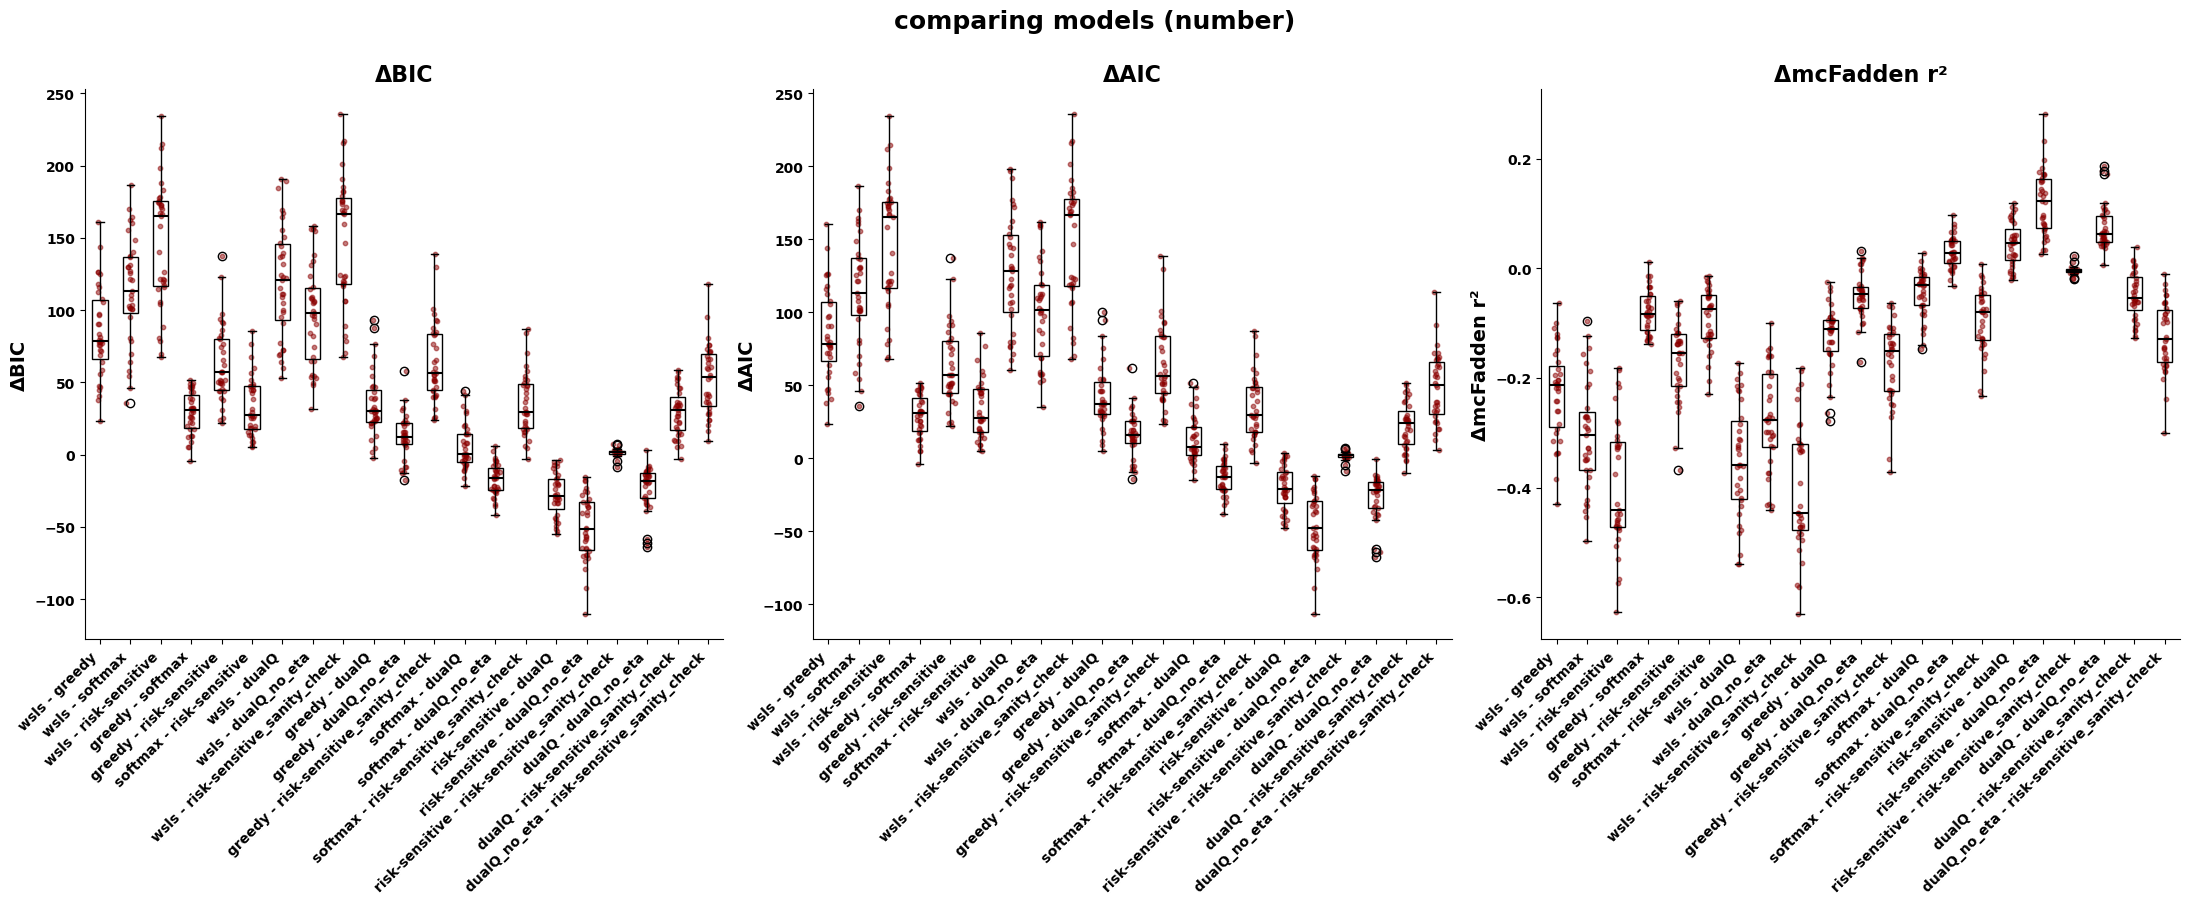

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(22, 10))

# Prepare deltas for all pairwise comparisons (wsls, greedy, softmax, rs)
bic_deltas = [
    delta_bic_wsls_greedy,
    delta_bic_wsls_softmax,
    delta_bic_wsls_rs,
    delta_bic_greedy_softmax,
    delta_bic_greedy_rs,
    delta_bic_softmax_rs,
    delta_bic_wsls_dualQ,
    delta_bic_wsls_dualQ_no_eta,
    delta_bic_wsls_rs_sanity_check,
    delta_bic_greedy_dualQ,
    delta_bic_greedy_dualQ_no_eta,
    delta_bic_greedy_rs_sanity_check,
    delta_bic_softmax_dualQ,
    delta_bic_softmax_dualQ_no_eta,
    delta_bic_softmax_rs_sanity_check,
    delta_bic_rs_dualQ,
    delta_bic_rs_dualQ_no_eta,
    delta_bic_rs_rs_sanity_check,
    delta_bic_dualQ_dualQ_no_eta,
    delta_bic_dualQ_rs_sanity_check,
    delta_bic_dualQ_no_eta_rs_sanity_check
]
aic_deltas = [
    delta_aic_wsls_greedy,
    delta_aic_wsls_softmax,
    delta_aic_wsls_rs,
    delta_aic_greedy_softmax,
    delta_aic_greedy_rs,
    delta_aic_softmax_rs,
    delta_aic_wsls_dualQ,
    delta_aic_wsls_dualQ_no_eta,
    delta_aic_wsls_rs_sanity_check,
    delta_aic_greedy_dualQ,
    delta_aic_greedy_dualQ_no_eta,
    delta_aic_greedy_rs_sanity_check,
    delta_aic_softmax_dualQ,
    delta_aic_softmax_dualQ_no_eta,
    delta_aic_softmax_rs_sanity_check,
    delta_aic_rs_dualQ,
    delta_aic_rs_dualQ_no_eta,
    delta_aic_rs_rs_sanity_check,
    delta_aic_dualQ_dualQ_no_eta,
    delta_aic_dualQ_rs_sanity_check,
    delta_aic_dualQ_no_eta_rs_sanity_check
]
mcFadden_r2_deltas = [
    delta_mcFadden_r2_wsls_greedy,
    delta_mcFadden_r2_wsls_softmax,
    delta_mcFadden_r2_wsls_rs,
    delta_mcFadden_r2_greedy_softmax,
    delta_mcFadden_r2_greedy_rs,
    delta_mcFadden_r2_softmax_rs,
    delta_mcFadden_r2_wsls_dualQ,
    delta_mcFadden_r2_wsls_dualQ_no_eta,
    delta_mcFadden_r2_wsls_rs_sanity_check,
    delta_mcFadden_r2_greedy_dualQ,
    delta_mcFadden_r2_greedy_dualQ_no_eta,
    delta_mcFadden_r2_greedy_rs_sanity_check,
    delta_mcFadden_r2_softmax_dualQ,
    delta_mcFadden_r2_softmax_dualQ_no_eta,
    delta_mcFadden_r2_softmax_rs_sanity_check,
    delta_mcFadden_r2_rs_dualQ,
    delta_mcFadden_r2_rs_dualQ_no_eta,
    delta_mcFadden_r2_rs_rs_sanity_check,
    delta_mcFadden_r2_dualQ_dualQ_no_eta,
    delta_mcFadden_r2_dualQ_rs_sanity_check,
    delta_mcFadden_r2_dualQ_no_eta_rs_sanity_check
]

labels = [
    "wsls - greedy",
    "wsls - softmax",
    "wsls - risk-sensitive",
    "greedy - softmax",
    "greedy - risk-sensitive",
    "softmax - risk-sensitive",
    "wsls - dualQ",
    "wsls - dualQ_no_eta",
    "wsls - risk-sensitive_sanity_check",
    "greedy - dualQ",
    "greedy - dualQ_no_eta",
    "greedy - risk-sensitive_sanity_check",
    "softmax - dualQ",
    "softmax - dualQ_no_eta",
    "softmax - risk-sensitive_sanity_check",
    "risk-sensitive - dualQ",
    "risk-sensitive - dualQ_no_eta",
    "risk-sensitive - risk-sensitive_sanity_check",
    "dualQ - dualQ_no_eta",
    "dualQ - risk-sensitive_sanity_check",
    "dualQ_no_eta - risk-sensitive_sanity_check"
]

# Plot BIC deltas
box_bic = axs[0].boxplot(
    bic_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_bic['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(bic_deltas):
    axs[0].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[0].set_title("ΔBIC", fontsize=16, fontweight='bold')
axs[0].set_ylabel("ΔBIC", fontsize=14, fontweight='bold')

# Plot AIC deltas
box_aic = axs[1].boxplot(
    aic_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_aic['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(aic_deltas):
    axs[1].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[1].set_title("ΔAIC", fontsize=16, fontweight='bold')
axs[1].set_ylabel("ΔAIC", fontsize=14, fontweight='bold')

# Plot McFadden R2 deltas
box_mcFadden = axs[2].boxplot(
    mcFadden_r2_deltas, vert=True, patch_artist=True, labels=labels,
    showmeans=False,
    medianprops={'color': 'black', 'linewidth': 1.5}
)
for box in box_mcFadden['boxes']:
    box.set(facecolor='none')
for i, delta in enumerate(mcFadden_r2_deltas):
    axs[2].scatter(np.random.normal(i + 1, 0.05, size=len(delta)), delta, alpha=0.5, s=10, color='#8b0000')
axs[2].set_title("ΔmcFadden r²", fontsize=16, fontweight='bold')
axs[2].set_ylabel("ΔmcFadden r²", fontsize=14, fontweight='bold')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle('comparing models (number)', fontsize=18, fontweight='bold', y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])

filename = os.path.join(output_dir, "models_evaluation_comparison_bic_r2_all_pairs_number.pdf")
plt.savefig(filename, format='pdf')
print(f"Saved: {filename}")

plt.show()
